#Data to fix model

In [ ]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
import numpy as np
from collections import Counter


def get_sublabel(df, label_name: str):
    unique_labels = df[label_name].unique()
    small_dataframes = {}
    for label in unique_labels:
        small_dataframes[label] = df[df[label_name] == label]
    return small_dataframes


def data_split(data,label_name: str, num_partitions: int, val_ratio: float = 0.1, IID: bool=True , clusted_in_subdata: int=1):
    '''
    data: input data
    label_name: name of target label in data
    num_partitions: number of Subdataset
    IID: (False for non iid data split)
    val_ratio: rate of validation data
    test_ratio: rate of test data
    '''
    if not IID :
        print("prepairing non IID dataset")
        length=len(data)
        partition_size=int(length/num_partitions)
        partition_len_list = [partition_size] * num_partitions
        print(f"len of client data :{partition_size * num_partitions}, len of each subdata : {partition_size}")
        data = data[:int(partition_size * num_partitions)]
        df_sorted = data.sort_values(by=label_name)
        df=df_sorted.reset_index(drop=True)

        partitions=[]
        start=0
        for num in partition_len_list:
            partitions.append(df[start:start+num])
            start=start+num
        num=1
        trainloaders = []
        valloaders = []
        for client in partitions:
            len_val = int(val_ratio * len(client))
            len_train = len(client) - len_val
            print(f"client number {num} : train({len_train}), val({len_val})")
            num=num+1
            client = client.sample(frac=1).reset_index(drop=True)
            val_data=client[0:len_val]
            train_data=client[len_val:]
            train_data = train_data.reset_index(drop=True)
            val_data=val_data.reset_index(drop=True)
            trainloaders.append(train_data)
            valloaders.append(val_data)

    if IID:
        print("prepairing IID dataset")
        partition_size = int(len(data) // num_partitions)
        partition_len_list = [partition_size] * num_partitions
        print(f"len of client data :{len(data)}, len of each subdata : {partition_size}")
        df = data[:int(partition_size * num_partitions)]
        partitions=[]
        start=0
        for num in partition_len_list:
            partitions.append(df[start:start+num])
            start=start+num

        trainloaders = []
        valloaders = []
        num=1
        for client in partitions:
            len_val = int(val_ratio * len(client))
            len_train = len(client) - len_val
            print(f"client number {num} : train({len_train}), val({len_val})")
            num=num+1
            val_data = client[0:len_val]
            train_data=client[len_val:]
            train_data = train_data.reset_index(drop=True)
            val_data=val_data.reset_index(drop=True)
            trainloaders.append(train_data)
            valloaders.append(val_data)
    return trainloaders, valloaders

def identify_correlated(df, threshold):
    """
    A function to identify highly correlated features.
    """
    # Compute correlation matrix with absolute values
    #df=df.drop("category",axis=1)
    matrix = df.corr().abs()

    # Create a boolean mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    # Subset the matrix
    reduced_matrix = matrix.mask(mask)

    # Find cols that meet the threshold
    to_drop = [c for c in reduced_matrix.columns if any(reduced_matrix[c] > threshold)]

    return to_drop

def processed(data,label_name: str,threshold: int=0.01, corr_threshold=1):
    label=data[label_name]
    data=data.drop(label_name,axis=1)
    data=pd.concat([label,data],axis=1)
    data.astype(str)
    df=data.dropna()
    label_encoder = LabelEncoder()
    encoded_df = df.apply(label_encoder.fit_transform)
    #feature selection
    selector = VarianceThreshold(threshold=threshold)
    filtered_df = selector.fit_transform(encoded_df)
    filtered_df = pd.DataFrame(filtered_df, columns=df.columns[selector.get_support()])
    #normalized
    normalized_df=filtered_df.mean()
    normalized_df=filtered_df.drop(identify_correlated(pd.DataFrame(normalized_df),corr_threshold),axis=1)
    processed_data=normalized_df
    processed_data=processed_data.sample(frac=1).reset_index(drop=True)
    return processed_data

def count_label_data(labels):
    '''
    this step use for analyse label
    '''
    label_counts = Counter(labels)
    return label_counts

def analyse_dataset(data,names):
    list=[]
    for name in names:
        label_data_count = count_label_data(data[name])
        print(f"thống kê nhãn {name}:")
        for label, count in label_data_count.items():
            list.append(label)
            print(label, count)
    return list


def group_labels(label_counts, n):
    grouped_labels = {}
    labels = list(label_counts.keys())
    # Duyệt qua từng cặp nhãn
    for i in range(0, len(labels), n):
        group =labels[i:i + n]
        group_key = tuple(group)
        group_count = sum(label_counts[label] for label in group)
        grouped_labels[group_key] = group_count

    return grouped_labels

def set_data(loaders):
    list=[]
    for loader in loaders:
        y=loader["subcategory "]
        X=loader.drop("subcategory ",axis=1)
        print(f"len X {len(X)}, len y {len(y)}")
        list.append((X,y))
    return list

In [ ]:
import pandas as pd
import numpy as np
df=pd.read_csv("/content/new2test.csv")
#delete all null columns
id=[16,17,21,22,23,24]
col=df.columns
for idx in id:
    df=df.drop(col[idx],axis=1)
data=processed(df,"subcategory ")

In [ ]:
data.columns

Index(['subcategory ', 'pkSeqID', 'stime', 'flgs', 'proto', 'saddr', 'sport',
       'daddr', 'dport', 'pkts', 'bytes', 'state', 'ltime', 'seq', 'dur',
       'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'srate', 'drate', 'attack', 'category'],
      dtype='object')

In [ ]:
X = data.drop("subcategory ",axis=1)
y =data["subcategory "]

In [ ]:
print(type(X))

<class 'pandas.core.frame.DataFrame'>


#Build MLP classifier model


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_size = 28
        self.output_size = 8
        self.criterion = nn.CrossEntropyLoss()
        self.lr = 0.003

        self.l1 = nn.Linear(self.input_size, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, self.output_size)

    def forward(self, inp):
        out = F.relu(self.l1(inp))
        out = F.relu(self.l2(out))
        out = self.l3(out)
        return out

    def convert(self, X, y):
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X.values, dtype=torch.float32)

        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y.values)

        return X, y

    def fit(self, X, y):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        for idx in range(X.shape[0]):

            #Get data
            features = torch.tensor([X.iloc[idx].values], dtype=torch.float, requires_grad = True)
            target = torch.tensor([y.iloc[idx]])

            optimizer.zero_grad()
            output = self(features)
            loss = self.criterion(output, target)
            loss.backward()
            optimizer.step()

            if idx % 10 == 0:
                print(f'Index {idx} - Loss: ', loss.item())

    def evaluate(self, X, y):

        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        for idx in range(X.shape[0]):
            features = torch.tensor([X.iloc[idx].values], dtype=torch.float, requires_grad = True)
            target = torch.tensor([y.iloc[idx]])

            optimizer.zero_grad()
            output = self(features)
            loss = self.criterion(output, target)

            if idx % 100 == 0:
                print(f'Index {idx} - Loss: ', loss.item())

    def get_parameters(self):

        params=self.state_dict()
        parameters=[]
        keys=[]
        for key,tensor in params.items():
            parameters.append(tensor)
            keys.append(key)
        self.params_key=keys
        return parameters

    def load_parameters(self, parameters_tensor):
        # Đảm bảo số lượng tham số trùng khớp
        assert len(self.params_key) == len(parameters_tensor), "Số lượng tham số không khớp"

        # Cập nhật giá trị của các tham số
        for key, tensor in zip(self.params_key, parameters_tensor):
            self.state_dict()[key].copy_(tensor)

##Test functions

In [ ]:
# Create model
model = MLP()

# Fit function
model.fit(X,y)

# Training loop
model.evaluate(X,y)

# Get paramenters
current_parameters = model.get_parameters()

# Load paramenters
model.load_parameters(current_parameters)

Index 0 - Loss:  171.71759033203125
Index 10 - Loss:  478.32574462890625
Index 20 - Loss:  0.0
Index 30 - Loss:  71.14947509765625
Index 40 - Loss:  0.0
Index 50 - Loss:  0.0
Index 60 - Loss:  0.0
Index 70 - Loss:  0.0
Index 80 - Loss:  32.532249450683594
Index 90 - Loss:  0.0
Index 100 - Loss:  0.0
Index 110 - Loss:  0.0
Index 120 - Loss:  0.0
Index 130 - Loss:  0.0
Index 140 - Loss:  68.5235366821289
Index 150 - Loss:  7.197129726409912
Index 160 - Loss:  0.0
Index 170 - Loss:  0.0
Index 180 - Loss:  0.007211014628410339
Index 190 - Loss:  0.0
Index 200 - Loss:  0.0
Index 210 - Loss:  0.0
Index 220 - Loss:  0.0
Index 230 - Loss:  0.0
Index 240 - Loss:  0.0
Index 250 - Loss:  0.0
Index 260 - Loss:  0.0
Index 270 - Loss:  0.012782072648406029
Index 280 - Loss:  0.0
Index 290 - Loss:  0.0
Index 300 - Loss:  0.0
Index 310 - Loss:  0.0
Index 320 - Loss:  0.0
Index 330 - Loss:  0.0
Index 340 - Loss:  153.5539093017578
Index 350 - Loss:  0.0
Index 360 - Loss:  0.0
Index 370 - Loss:  0.0
Ind

#Build generator

In [ ]:
import argparse
import os
import numpy as np
import math
import random
import numpy as np
from torch.autograd import Variable

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=1000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=100, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0001, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--features", type=int, default=28, help="number of features")
parser.add_argument("--num_labels", type=int, default=8, help="number of labels")
opt = parser.parse_args(args=[])
print(opt)

Tensor = torch.FloatTensor

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.features // 4
        self.l1 = nn.Sequential(nn.Linear(opt.num_labels*2, 128 * self.init_size))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(size = [1, self.init_size*2]),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(size = [1, self.init_size*4]),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
            )

    def forward(self, label):
        z = Variable(Tensor(np.random.normal(0, 1, (opt.batch_size, opt.num_labels))), requires_grad=True)
        print(z.shape)
        out = self.l1(torch.cat((z, label), axis = 1))
        out = out.view(opt.batch_size, 128, 1, self.init_size)
        data = self.conv_blocks(out)
        return data


Namespace(n_epochs=1000, batch_size=100, lr=0.0001, b1=0.5, b2=0.999, n_cpu=8, features=28, num_labels=8)


In [ ]:
# Create Generator
g = Generator()
CE = torch.nn.CrossEntropyLoss()
optimizer_G = torch.optim.Adam(g.parameters(), lr=opt.lr)
losses = []

for epoch in range(opt.n_epochs):
    # Tạo dữ liệu đầu vào ngẫu nhiên
    y = torch.randint(0, 8, (opt.batch_size,))
    y_encoded = F.one_hot(y, 8).float()
    # Xóa gradient của Generator
    optimizer_G.zero_grad()

    # Tính toán output từ Generator
    g_ = g(y_encoded).reshape(opt.batch_size, 28)
    print(g_.shape)
    # Tính toán dự đoán từ Discriminator
    y_pred = model(g_)
    # Tính loss và gradient
    loss = CE(y_pred, y)
    loss.backward()
    # Cập nhật các tham số của Generator
    optimizer_G.step()

    losses.append(loss.item())
    print(f"Epoch [{epoch}/{opt.n_epochs}], Loss: {loss.item()}")

torch.Size([100, 8])
torch.Size([100, 28])
Epoch [0/1000], Loss: 2.2383806705474854
torch.Size([100, 8])
torch.Size([100, 28])
Epoch [1/1000], Loss: 2.193265914916992
torch.Size([100, 8])
torch.Size([100, 28])
Epoch [2/1000], Loss: 2.2458088397979736
torch.Size([100, 8])
torch.Size([100, 28])
Epoch [3/1000], Loss: 2.3317465782165527
torch.Size([100, 8])
torch.Size([100, 28])
Epoch [4/1000], Loss: 2.3813774585723877
torch.Size([100, 8])
torch.Size([100, 28])
Epoch [5/1000], Loss: 2.285121202468872
torch.Size([100, 8])
torch.Size([100, 28])
Epoch [6/1000], Loss: 2.2574105262756348
torch.Size([100, 8])
torch.Size([100, 28])
Epoch [7/1000], Loss: 2.365403652191162
torch.Size([100, 8])
torch.Size([100, 28])
Epoch [8/1000], Loss: 2.368767023086548
torch.Size([100, 8])
torch.Size([100, 28])
Epoch [9/1000], Loss: 2.401935577392578
torch.Size([100, 8])
torch.Size([100, 28])
Epoch [10/1000], Loss: 2.3768482208251953
torch.Size([100, 8])
torch.Size([100, 28])
Epoch [11/1000], Loss: 2.387448310852

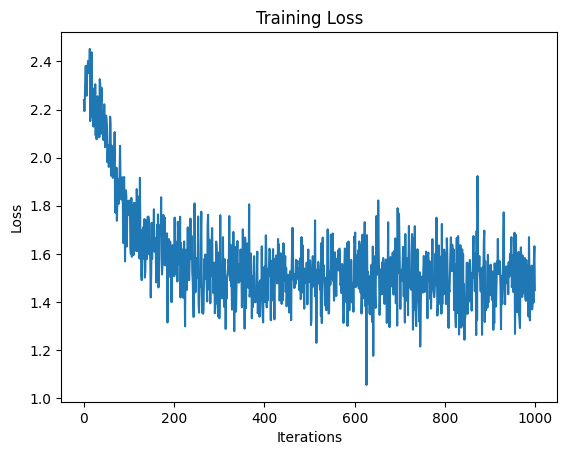

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Vẽ biểu đồ loss
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()